# Graded Programming Assignment

In this assignment, you will implement re-use the unsupervised anomaly detection algorithm but turn it into a simpler feed forward neural network for supervised classification.

You are training the neural network from healthy and broken samples and at later stage hook it up to a message queue for real-time anomaly detection.

We've provided a skeleton for you containing all the necessary code but left out some important parts indicated with ### your code here ###

After you’ve completed the implementation please submit it to the autograder


# imports

try to import all necessary 3rd party packages which are not already part of the default data science experience installation

note: If you are running outside data science experience you might need a "!pip install pandas scikit-learn tensorflow" 

In [1]:
import pip

try:
    __import__('keras')
except ImportError:
    pip.main(['install', 'keras']) 
    
try:
    __import__('ibmiotf')
except ImportError:
    pip.main(['install', 'ibmiotf']) 

Using TensorFlow backend.


  Running setup.py bdist_wheel for ibmiotf: started
  Running setup.py bdist_wheel for ibmiotf: finished with status 'done'
  Stored in directory: /gpfs/fs01/user/sadd-fa032262be91f5-5612ce30aaa0/.cache/pip/wheels/6c/cf/f0/483e80c9c73f11d5a7f3c9c867abe6dcfd7e9de070f4ebe183
  Running setup.py bdist_wheel for paho-mqtt: started
  Running setup.py bdist_wheel for paho-mqtt: finished with status 'done'
  Stored in directory: /gpfs/fs01/user/sadd-fa032262be91f5-5612ce30aaa0/.cache/pip/wheels/38/ca/67/86c7e4acc659ce5ab74cbb8cc38de50c90ed4f827133e36994
  Running setup.py bdist_wheel for dicttoxml: started
  Running setup.py bdist_wheel for dicttoxml: finished with status 'done'
  Stored in directory: /gpfs/fs01/user/sadd-fa032262be91f5-5612ce30aaa0/.cache/pip/wheels/62/4f/a3/afd4a68f5add45a668c14efa53b64d5cffb2be6bacf993c151
Successfully built ibmiotf paho-mqtt dicttoxml


Now we import all the rest

In [2]:
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ibmiotf.application
import sys
from queue import Queue
import pandas as pd
import json
%matplotlib inline

We grab the files necessary for taining. Those are sampled from the lorenz attractor model implemented in NodeRED. Those are two serialized pickle numpy arrays

In [4]:
!rm watsoniotp.*
!wget https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.healthy.phase_aligned.pickle
!wget https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.broken.phase_aligned.pickle
!mv watsoniotp.healthy.phase_aligned.pickle watsoniotp.healthy.pickle
!mv watsoniotp.broken.phase_aligned.pickle watsoniotp.broken.pickle

--2018-06-23 16:49:35--  https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.healthy.phase_aligned.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 194639 (190K) [text/plain]
Saving to: ‘watsoniotp.healthy.phase_aligned.pickle’

100%[======================================>] 194,639     --.-K/s   in 0.008s  

2018-06-23 16:49:36 (22.1 MB/s) - ‘watsoniotp.healthy.phase_aligned.pickle’ saved [194639/194639]

--2018-06-23 16:49:36--  https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.broken.phase_aligned.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request se

De-serialize the numpy array containing the training data

In [5]:
data_healthy = pickle.load(open('watsoniotp.healthy.pickle', 'rb'), encoding='latin1')
data_broken = pickle.load(open('watsoniotp.broken.pickle', 'rb'), encoding='latin1')

Reshape to three columns and 3000 rows. In other words three vibration sensor axes and 3000 samples

In [6]:
data_healthy = data_healthy.reshape(3000,3)
data_broken = data_broken.reshape(3000,3)

Since this data is sampled from the Lorenz Attractor Model, let's plot it with a phase lot to get the typical 2-eyed plot. First for the healthy data

Text(0.5,0.92,'Lorenz Attractor')

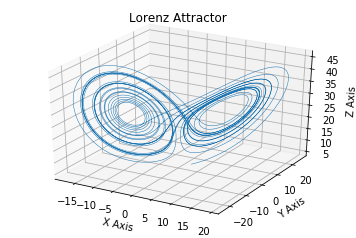

In [7]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(data_healthy[:,0], data_healthy[:,1], data_healthy[:,2],lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

Then for the broken one

Text(0.5,0.92,'Lorenz Attractor')

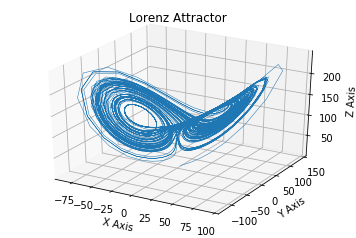

In [8]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(data_broken[:,0], data_broken[:,1], data_broken[:,2],lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

In the previous examples, we fed the raw data into an LSTM. Now we want to use an ordinary feed-forward network. So we need to do some pre-processing of this time series data

A widely-used method in traditional data science and signal processing is called Discrete Fourier Transformation. This algorithm transforms from the time to the frequency domain, or in other words, it returns the frequency spectrum of the signals.

The most widely used implementation of the transformation is called FFT, which stands for Fast Fourier Transformation, let’s run it and see what it returns


In [ ]:
data_healthy_fft = np.fft.fft(data_healthy)
data_broken_fft = np.fft.fft(data_broken)

Let’s first have a look at the shape and contents of the arrays.

In [ ]:
print (data_healthy_fft.shape)
print (data_healthy_fft)

First, we notice that the shape is the same as the input data. So if we have 3000 samples, we get back 3000 spectrum values, or in other words 3000 frequency bands with the intensities.

The second thing we notice is that the data type of the array entries is not float anymore, it is complex. So those are not complex numbers, it is just a means for the algorithm the return two different frequency compositions in one go. The real part returns a sine decomposition and the imaginary part a cosine. We will ignore the cosine part in this example since it turns out that the sine part already gives us enough information to implement a good classifier.

But first let’s plot the two arrays to get an idea how a healthy and broken frequency spectrum differ


In [ ]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
ax.plot(range(0,size), data_healthy_fft[:,0].real, '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy_fft[:,1].real, '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy_fft[:,2].real, '-', color='green', animated = True, linewidth=1)

In [ ]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
ax.plot(range(0,size), data_broken_fft[:,0].real, '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken_fft[:,1].real, '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken_fft[:,2].real, '-', color='green', animated = True, linewidth=1)

So, what we've been doing is so called feature transformation step. We’ve transformed the data set in a way that our machine learning algorithm – a deep feed forward neural network implemented as binary classifier – works better. So now let's scale the data to a 0..1

In [ ]:
def scaleData(data):
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(data)

And please don’t worry about the warnings. As explained before we don’t need the imaginary part of the FFT

In [ ]:
data_healthy_scaled = scaleData(data_healthy_fft)
data_broken_scaled = scaleData(data_broken_fft)

Now we reshape again to have three examples (rows) and 3000 features (columns). It's important that you understand this. We have turned our initial data set which containd 3 columns (dimensions) of 3000 samples. Since we applied FFT on each column we've obtained 3000 spectrum values for each of the 3 three columns. We are now using each column with the 3000 spectrum values as one row (training example) and each of the 3000 spectrum values becomes a column (or feature) in the training data set

In [ ]:
data_healthy_scaled.shape = (3, 3000)
data_broken_scaled.shape = (3, 3000)

# Start of Assignment

The first thing we need to do is to install a little helper library for submitting the solutions to the coursera grader:

In [ ]:
!rm -f rklib.py
!wget https://raw.githubusercontent.com/romeokienzler/developerWorks/master/coursera/ai/rklib.py

Please specify you email address you are using with cousera here:

In [ ]:
from rklib import submit, submitAll
key = "4vkB9vnrEee8zg4u9l99rA"
all_parts = ["O5cR9","0dXlH","ZzEP8"]

email = "###_YOUR_CODE_GOES_HERE_###"


## Task

Given, the explanation above, please fill in the following two constants in order to make the neural network work properly

In [ ]:
#### your code here ###
dim = #### your code here ###
samples = #### your code here ###

### Submission

Now it’s time to submit your first solution. Please make sure that the secret variable contains a valid submission token. You can obtain it from the courser web page of the course using the grader section of this assignment.


In [ ]:
part = "O5cR9"
secret = "###_YOUR_CODE_GOES_HERE_###"

submitAll(email, secret, key, dict((p, json.dumps({}) if p != part else json.dumps({"dim": dim, "samples": samples})) for p in all_parts))

To observe how training works we just print the loss during training

In [ ]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        sys.stdout.write(str(logs.get('loss'))+str(', '))
        sys.stdout.flush()
        self.losses.append(logs.get('loss'))
        
lr = LossHistory()

## Task

Please fill in the following constants to properly configure the neural network. For some of them you have to find out the precise value, for others you can try and see how the neural network is performing at a later stage. The grader only looks at the values which need to be precise


In [ ]:
number_of_neurons_layer1 = #### your code here ###
number_of_neurons_layer2 = #### your code here ###
number_of_neurons_layer3 = #### your code here ###
number_of_epochs = #### your code here ###

### Submission

Please submit your constants to the grader

In [ ]:
parts_data = {}
parts_data["0dXlH"] = json.dumps({"number_of_neurons_layer1": number_of_neurons_layer1, "number_of_neurons_layer2": number_of_neurons_layer2, "number_of_neurons_layer3": number_of_neurons_layer3, "number_of_epochs": number_of_epochs})
parts_data["O5cR9"] = json.dumps({"dim": dim, "samples": samples})
parts_data["ZzEP8"] = None 
                                 
                                 
secret = "###_YOUR_CODE_GOES_HERE_###"


submitAll(email, secret, key, parts_data)

## Task

Now it’s time to create the model. Please fill in the placeholders. Please note since this is only a toy example, re don't use a separate corpus for training and testing. Just use the same data for fitting and scoring


In [ ]:
# design network
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, clipnorm=1.)

model = Sequential()
model.add(Dense(number_of_neurons_layer1,input_shape=(dim, ), activation='relu'))
model.add(Dense(number_of_neurons_layer2, activation='relu'))
model.add(Dense(number_of_neurons_layer3, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=sgd)

def train(data,label):
    model.fit(#### your code here ###, #### your code here ###, epochs=number_of_epochs, batch_size=72, validation_data=(data, label), verbose=0, shuffle=True,callbacks=[lr])

def score(data):
    return model.#### your code here ###(data)

In [ ]:
#some learners constantly reported 502 errors in Watson Studio. 
#This is due to the limited resources in the free tier and the heavy resource consumption of Keras.
#This is a workaround to limit resource consumption

from keras import backend as K

K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))


We prepare the training data by concatenating a label “0” for the broken and a label “1” for the healthy data. Finally we union the two data sets together

In [ ]:
label_healthy = np.repeat(1,3)
label_healthy.shape = (3,1)
label_broken = np.repeat(0,3)
label_broken.shape = (3,1)

train_healthy = np.hstack((data_healthy_scaled,label_healthy))
train_broken = np.hstack((data_broken_scaled,label_broken))
train_both = np.vstack((train_healthy,train_broken))

Let’s have a look at the two training sets for broken and healthy and at the union of them. Note that the last column is the label

In [ ]:
pd.DataFrame(train_healthy)

In [ ]:
pd.DataFrame(train_broken)

In [ ]:
pd.DataFrame(train_both)

So those are frequency bands. Notice that although many frequency bands are having nearly the same energy, the neural network algorithm still can work those out which are significantly different. 

## Task

Now it’s time to do the training. Please provide the first 3000 columns of the array as the 1st parameter and column number 3000 containing the label as 2nd parameter. Please use the python array slicing syntax to obtain those. 

The following link tells you more about the numpy array slicing syntax
https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html


In [ ]:
features = train_both[:,#### your code here ###]
labels = train_both[:,#### your code here ###]

Now it’s time to do the training. You should see the loss trajectory go down, we will also plot it later. Note: We also could use TensorBoard for this but for this simple scenario we skip it. In some rare cases training doesn’t converge simply because random initialization of the weights caused gradient descent to start at a sub-optimal spot on the cost hyperplane. Just recreate the model (the cell which contains *model = Sequential()*) and re-run all subsequent steps and train again



In [ ]:
train(features,labels)

Let's plot the losses

In [ ]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(lr.losses)
ax.plot(range(0,size), lr.losses, '-', color='blue', animated = True, linewidth=1)

Now let’s examine whether we are getting good results. Note: best practice is to use a training and a test data set for this which we’ve omitted here for simplicity

In [ ]:
score(data_healthy_scaled)

In [ ]:
score(data_broken_scaled)


## Task

Now it’s time to hook this up to the message queue for real-time data analysis. Please provide your credentials here. You’ve learned how to obtained them in the 1st week of the course in the lecture called “Setup the NodeRED Boilerplate”, at the end of the video. Of course, you need to install your own instance in the IBM Cloud.

IMPORTANT NOTE: In case you haven't setup the TestData Generator, please do so. You can watch me doing this in the video "Setup the NodeRED Boilerplate" of Week 1. The important steps are shown around 2 minutes 30 seconds.

If you want to learn more about the physical model and the simulator as a whole, I've documented this here:

https://www.ibm.com/developerworks/analytics/library/iot-deep-learning-anomaly-detection-2/index.html?ca=drs-

BTW: This article is part of a 5 part series on anomaly detection I've written last year :)

If you just need the JSON of the NodeRED flow, you can find it here:

https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/simulatorflow.json

I'm deeply thankful to Nicole Finnie, one of the learners, to point out this missing information.


In [ ]:
options = {"org": "#### your code here ###", "id": "anything", "auth-method": "apikey", "auth-key": "#### your code here ###", "auth-token": "#### your code here ###"}
client = ibmiotf.application.Client(options)
client.connect()

Let’s create a python queue for our data

In [ ]:
q = Queue(7000)

To subscribe to real time data, we need to specify a callback handler where we extract and reformat the data, register the callback handler to the MQTT client and select the type of events we want to subscribe to


In [ ]:
def myEventCallback(event):
    sample = event.data
    point = [sample["x"], sample["y"],sample["z"]]
    q.put(point)

client.deviceEventCallback = myEventCallback
client.subscribeToDeviceEvents("0.16.2", "lorenz", "osc")

Before we can call the neural network scoring (or predicting) function we need to pre-proceed the raw data in the same way as we have done for the static data we’ve used for training. Note that we take the average score over the three samples. Finally, we push the result back the message queue.


### Submission

In case you feel confident that everything works as it should you can set *submit_work* to True and again please make sure that the secret variable contains a valid submission token. Please make sure to re-run the whole scenario end-2-end from the TestDataGenerator in NodeRED so that the grader can pick up your result based on the live stream of data.

Please open NodeRED and click on “reset” on the test data generator. On the debug tab you should see the data generated and in the notebook you should see little dots apprearing, one for each message received. Once 3000 messages have been received, the data is sent downstream to your neural network and once it has finished the anomaly score will be sent to the grader for grading



In [ ]:
submit_work = False ###_YOUR_CODE_GOES_HERE_### => set to True in case you want to submit to the grader
parts_data = {}
parts_data["0dXlH"] = json.dumps({"number_of_neurons_layer1": number_of_neurons_layer1, "number_of_neurons_layer2": number_of_neurons_layer2, "number_of_neurons_layer3": number_of_neurons_layer3, "number_of_epochs": number_of_epochs})
parts_data["O5cR9"] = json.dumps({"dim": dim, "samples": samples})

                                 
                                 
secret = "###_YOUR_CODE_GOES_HERE_###"

In [ ]:
def doNN(data):
    global submit_work
    data_fft = np.fft.fft(data)
    data_scaled = scaleData(data_fft)
    data_scaled_reshaped = data_scaled
    data_scaled_reshaped.shape = (3, 3000)
    prediction = str(np.sum(score(data_scaled_reshaped))/3)
    print ("Prediction: %s, publishing..." % (prediction))
    myData={'healthy' : prediction}
    client.publishEvent("0.16.2", "lorenz", "status", "json", myData)
    if submit_work:
        submit_work = False
        parts_data["ZzEP8"] = json.dumps(myData)
        submitAll(email, secret, key, parts_data)
        print ("Submitting to grader: %s" % (json.dumps(myData)))
    print ("Done")

Now it’s time to start the endless loop to wait for data arriving in the queue. Once started please start generating data using the NodeRED test data generator. 

IMPORTANT: You are blocking the kernel now, so the only way to escape is to click on “Kernel->Restart & Clear Output” and wait until all outputs disappear. Then you can start over from scratch. 

You can also choose “Cell->Run all”

Rarely you might get an “memory error”, in case too many students on the free tier are pushing load to the underlying Kubernetes engine. So, in that case just start over as described above by restarting the kernel and run all again WITHOUT using the “Run all” method, just run each cell, one by one and wait until it has completed (by waiting for the asterisk being replaced by a number)

In [ ]:
import numpy as np
while True:
    while not q.empty():
        sys.stdout.write('.')
        sys.stdout.flush()
        point = q.get()
        try:
            data
        except NameError:
            data = np.array(point)
        else:
            data = np.append(data,point)
        if data.size>=9000:
            data = np.reshape(data,(3000,3))
            print ("Sending window downstream to the neural network...")
            doNN(data)
            print ("Training finished...")
            del data


In case you get some reshaping errors, just execute the following line and start over with the previous cell

In [ ]:
del data